A CREMA-D (Crowd-sourced Emotional Multimodal Actors Dataset) rövid, pár másodperces videófelvételeket tartalmaz. A videókon 91 különboző életkorú, nemi és etnikai háttérrel rendelkező színész szerepel. Egy videófelvétel 6 különbőző érzelem egyikét reprezentálja: harag, undor, félelem, boldogság, közömbösség, szomorúság. Minden videóhoz tartozik egy intenzitási ráta: alacsony, közepes, magas és nem meghatározott. Ezeket az intenzitásokat a jenlegi modell nem veszi figyelembe. Minden videóhoz egy mondat is társul, melyet az adott színész a reprezentált érzelem és intenzitás fényében mond ki, ezt szintén nem veszi számításba a modell a predikcióhoz.

In [ ]:
!git clone https://github.com/CheyneyComputerScience/CREMA-D
%cd CREMA_D

Cloning into 'CREMA-D'...
remote: Enumerating objects: 22501, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 22501 (delta 22), reused 57 (delta 13), pack-reused 22428 (from 1)
Receiving objects: 100% (22501/22501), 14.82 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (75/75), done.
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'


Exiting because of "interrupt" signal.
^C
[Errno 2] No such file or directory: 'CREMA_D'
/content


A tanítóvideók eredetilegy 640x480 felbontásúak és flv formátumban vannak tárolva. Az előfeldolgozás első lépése átkonvertálni mp4-be, downscalelni őket, majd kivágni, úgy, hogy négyzetesek legyenek és lehetőleg a legkevessebb információ vesszen el. Ezt a folyamatot a ffmpeg programmal hajtom végre. A videók végső felbontása 224x224, mert a kísérletezésnél felhasznált InceptionResNetV2 és MobileNetV2 default bemenete is ekkore felbontású.

(Ezt a lépést előre elvégeztem az eredmények a google driveom AI/Extracted mappájában vannak.)

In [ ]:
!apt install ffmpeg


import os
import glob
import subprocess

src = "/content/CREMA-D/VideoFlash"  # Az input fájlok helye
dst = "/content/CREMA-D/Extracted"  # Az output fájlok helye

os.makedirs(dst, exist_ok=True)

# Fájlok törlése egy adott mappából
def delete_files_in_directory(directory_path):
    try:
        files = glob.glob(os.path.join(directory_path, '*'))
        for file in files:
            if os.path.isfile(file):
                os.remove(file)
        print("All files deleted successfully.")
    except OSError:
        print("Error occurred while deleting files.")

# FFmpeg paraméterek
ffmpeg_downscale_args = "scale=360:270"
ffmpeg_crop_to_square_args = "crop=224:224:(iw-224)/2:(ih-224)/2"

ffmpeg_args = ffmpeg_downscale_args + "," + ffmpeg_crop_to_square_args

# Töröljük a cél mappát (ha szükséges)
delete_files_in_directory(dst)

# Feldolgozzuk az összes .flv fájlt az input könyvtárban
for root, dirs, filenames in os.walk(src, topdown=False):
    for filename in filenames:
        if filename.endswith(".flv"):
            inputfile = os.path.join(root, filename)
            print(f"Processing: {inputfile}")
            outputfile = os.path.join(dst, filename.replace(".flv", ".mp4"))

            # FFmpeg parancs végrehajtása
            subprocess.run(['ffmpeg', '-i', inputfile, "-vf", ffmpeg_args, outputfile])

print("Processing completed.")


All files deleted successfully.
Processing: /content/CREMA-D/VideoFlash/1080_TIE_ANG_XX.flv
Processing: /content/CREMA-D/VideoFlash/1084_ITS_FEA_XX.flv
Processing: /content/CREMA-D/VideoFlash/1066_ITH_SAD_XX.flv
Processing: /content/CREMA-D/VideoFlash/1045_TSI_DIS_XX.flv
Processing: /content/CREMA-D/VideoFlash/1068_IWW_SAD_XX.flv
Processing: /content/CREMA-D/VideoFlash/1069_WSI_FEA_XX.flv
Processing: /content/CREMA-D/VideoFlash/1049_TAI_FEA_XX.flv
Processing: /content/CREMA-D/VideoFlash/1005_IWL_FEA_XX.flv
Processing: /content/CREMA-D/VideoFlash/1045_TIE_ANG_XX.flv
Processing: /content/CREMA-D/VideoFlash/1046_TSI_ANG_XX.flv
Processing: /content/CREMA-D/VideoFlash/1023_TSI_HAP_XX.flv
Processing: /content/CREMA-D/VideoFlash/1057_DFA_ANG_XX.flv
Processing: /content/CREMA-D/VideoFlash/1041_IEO_HAP_LO.flv
Processing: /content/CREMA-D/VideoFlash/1088_IOM_FEA_XX.flv
Processing: /content/CREMA-D/VideoFlash/1048_TIE_DIS_XX.flv
Processing: /content/CREMA-D/VideoFlash/1053_ITS_DIS_XX.flv
Processi

Ahhoz hogy gyorsabb legyen a tanító adatbázishoz történő hozzáférés google driveon tárolva vannak a videófelvételek csökkentett felbontású változatai (Extracted). Hozzáférésükhoz mount-olni kell a drive-ot.

A collab belső fájlrendszere sokkal gyorsabb fájl hozzáférést nyújt, a drive-ról történő olvasáshoz képest, ezért érdemes átmásolni a tanító adatokat a collab rendszerre.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/dataset
!cp "/content/drive/MyDrive/AI/Extracted" /content/dataset -r
!cp "/content/drive/MyDrive/AI/SentenceFilenames.csv" /content/dataset -r

Mounted at /content/drive


Az érzelmek (SAD, HAP, FEA, ANG, DIS, NEU) 0-tól 5-ig vannak kódolva. A SentenceFilenames.csv tartalmazza a fájlneveket, ezt a fájt olvassák be a CremaDataLoaderek és csak igény szerint töltik be a konkrét videók frame-jeit, ezeket nem tárolják. A load_crema_dataset függvény adja vissza a train és test dataloadereket a split_test paraméterrel lehet állítani a teszt adathalmaz méretét a teljeshez képest. A samples paraméter adja meg hogy egy videóból hány frame-et mintavételezünk. A mintavételezés egyenletes eloszlást követ.

In [ ]:
!pip install keras


import asyncio
import csv
import math
import numpy as np
import cv2 as cv
import os

from tensorflow.keras.utils import Sequence

FRAME_DIMS = (224, 224) # A videók felbontása
INPUT_SHAPE = (FRAME_DIMS[0], FRAME_DIMS[1], 3) # Channel last ábrázolás


EMOTIONS = ["SAD", "HAP", "FEA", "ANG", "DIS", "NEU"]


def encode_emotion(emotion: str):
    return EMOTIONS.index(emotion)


def decode_emotion(code: int):
    return EMOTIONS[code]


def get_label(filename):
    emotion = filename.split('_')[2]
    return encode_emotion(emotion)

def index_of_most_frequent(arr):
    counts = np.bincount(arr)
    return np.argmax(counts)

files_with_errors = ["1076_MTI_NEU_XX","1076_MTI_SAD_XX","1064_TIE_SAD_XX","1064_IEO_DIS_MD"]

# A videóneveket tartalmazó fájl feldolgozása
def parse_summary(filenames_file, filter_emotion):
    def filter_filename(file):
        if file in files_with_errors:
          return False
        parts = file.split('_')
        return parts[-2] in filter_emotion

    with open(filenames_file) as f:
        next(f)
        reader = csv.reader(f)
        filenames = [s[1] for s in reader]
        filenames = list(filter(filter_filename, filenames))
        return (np.array([f + ".mp4" for f in filenames]),
                np.array([get_label(f) for f in filenames]))


# A CREMA-D train és test dataloaderek előállítása
def load_crema_dataset(summary_file="/content/dataset/SentenceFilenames.csv",
                       video_dir="/content/dataset/Extracted",
                       samples=10,
                       split_test=0.2,split_val=0.1,
                       batch_size=32) -> (Sequence, Sequence, Sequence):
    files, labels = parse_summary(summary_file,EMOTIONS)
    shuffler = np.random.permutation(len(files))
    print(len(files), len(labels))
    files = files[shuffler]
    labels = labels[shuffler]
    train_end = math.floor(len(files)*(1-(split_test+split_val)))
    test_end = math.floor(len(files)*(1-split_val))
    train = files[:train_end], labels[:train_end]
    test = files[train_end:test_end], labels[train_end:test_end]
    val = files[test_end:], labels[test_end:]
    return (CremaDataloader(train[0], train[1], video_dir, samples, batch_size),
            CremaDataloader(test[0], test[1], video_dir, samples, batch_size),
            CremaDataloader(val[0], val[1], video_dir, samples, batch_size))



class CremaDataloader(Sequence):
    def __init__(self, videos, labels, video_dir, samples, batch_size):
        super().__init__()
        self.videos = videos
        self.labels = labels
        self.video_dir = video_dir
        self.samples = samples
        self.batch_size = batch_size

    def __len__(self):
        return math.floor(len(self.videos) / self.batch_size)

    def __getitem__(self, idx):
        frames = self.__load_datafiles(self.videos[idx * self.batch_size:(idx + 1) * self.batch_size])
        labels = np.zeros((self.batch_size, len(EMOTIONS)))
        ind = 0
        for label in self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]:
            labels[ind][label] = 1
            ind += 1
        return frames, labels

    # Visszaadja a használt videók címkéjét sorrendben
    def get_used_labels(self):
        return self.labels[:len(self)*self.batch_size]

    # A frame-ek kinyerése egy videó esetén
    def __extract_frames_from_video(self, video_path) -> np.ndarray:
        output = []
        cap = cv.VideoCapture(video_path)
        success, frame = cap.read()
        while success:
            output.append(frame)
            success, frame = cap.read()
        output = np.array(output)
        indices = np.linspace(0, len(output) - 1, self.samples, dtype=int)
        return np.divide(output[indices], 255)

    def __load_datafiles(self, filenames):
        return np.array([
            self.__extract_frames_from_video(os.path.join(self.video_dir, file)) for file in filenames])

In [ ]:
batch_size = 32
n_samples = 12
dataset_train, dataset_test, dataset_val = load_crema_dataset(batch_size=batch_size, samples=n_samples)

7438 7438


A feladat megoldására CNN + LSTM (N->1) modellt használok.

A CNN modell egy előre tanított MobileNetV2 segítségével végzi a predikciókat. Eredetileg InceptionResNetV2 modellel végeztem a tanítást, de nem adott sokkal pontosabb becsléseket, viszont láthatóan növelte a már nagy tanítási időt.

In [ ]:
import os.path
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class ClassificationModel:
    def __init__(self):
        self.save_dir = "/content/drive/MyDrive/AI/"

    def compile(self):
        self.model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

    def train(self, dataset_train, dataset_val, n_epochs=10, batch_size=32):
        self.compile()
        history = self.model.fit(dataset_train, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=dataset_val)
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.show()
        self.save()


    def test(self,dataset_test,batch_size=32):
        test_acc=self.model.evaluate(dataset_test,batch_size=batch_size)
        test_acc=test_acc[1]
        y_true = dataset_test.get_used_labels()
        y_pred = np.argmax(self.model.predict(dataset_test,batch_size=batch_size),axis=1)
        result = confusion_matrix(y_true, y_pred , normalize='pred')
        sns.heatmap(result, annot=True)
        print("The accuracy on the test data is: ",test_acc)


    def save(self):
        self.model.save_weights(self.save_dir+self.save_file)

    def load(self):
        if os.path.isfile(self.save_dir+self.save_file):
            self.model.load_weights(self.save_dir+self.save_file)
            self.compile()


class RnnModel(ClassificationModel):
    def __init__(self):
        super().__init__()
        self.cnn_input = keras.layers.Input(shape=INPUT_SHAPE)
        self.pretrained = tf.keras.applications.MobileNetV2(include_top=False,input_shape=INPUT_SHAPE)
        self.pretrained.trainable = False
        self.feature_extractor = tf.keras.Sequential([
            keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
            keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
            keras.layers.Flatten()
        ])
        x = self.cnn_input
        x = self.pretrained(x)
        x = self.feature_extractor(x)
        self.cnn_model = keras.Model(inputs=self.cnn_input, outputs=x)

        self.classifier = tf.keras.Sequential([
            keras.layers.Input(shape=(None,INPUT_SHAPE[0],INPUT_SHAPE[1],INPUT_SHAPE[2])),
            keras.layers.TimeDistributed(self.cnn_model),
            keras.layers.LSTM(10, activation='relu', return_sequences=False,use_bias=True),
            keras.layers.Dense(16, activation='linear'),
            keras.layers.Dense(len(EMOTIONS), activation='softmax'),
        ])

        self.model = self.classifier
        self.model.summary()
        self.save_file = "rnn_model.weights.h5"

In [ ]:
rnn_model = RnnModel()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_7 (TimeDistributed) │ (None, None, 64)            │      54,796,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 10)                  │           3,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,800,046 (209.05 MB)

 Trainable params: 463,246 (1.77 MB)

 Non-trainable params: 54,336,800 (207.28 MB)

Epoch 1/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.2744 - loss: 1.6804 - val_accuracy: 0.4185 - val_loss: 1.4048
Epoch 2/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.4931 - loss: 1.2725 - val_accuracy: 0.5211 - val_loss: 1.2052
Epoch 3/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5589 - loss: 1.0923 - val_accuracy: 0.5700 - val_loss: 1.0961
Epoch 4/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.6499 - loss: 0.9193 - val_accuracy: 0.6033 - val_loss: 1.0092
Epoch 5/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6838 - loss: 0.8046 - val_accuracy: 0.5958 - val_loss: 1.1190
Epoch 6/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7324 - loss: 0.6998 - val_accuracy: 0.6637 - val_loss: 0.9334
Epoch 7/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7664 - loss: 0.6247 - val_accuracy: 0.6467 - val_loss: 1.0478
Epoch 8/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8004 - loss: 0.5344 - val_accu

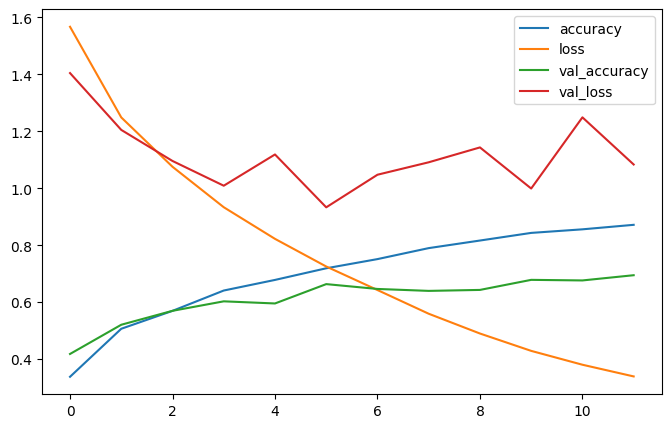

In [ ]:
rnn_model.train(dataset_train,dataset_val,n_epochs=12,batch_size=batch_size)

Ha már van tanított modell betöltjuk a súlyait.

In [ ]:
rnn_model.load()

23/23 ━━━━━━━━━━━━━━━━━━━━ 168s 910ms/step - accuracy: 0.8090 - loss: 0.6025
23/23 ━━━━━━━━━━━━━━━━━━━━ 120s 868ms/step
The accuracy on the test data is:  0.8179348111152649


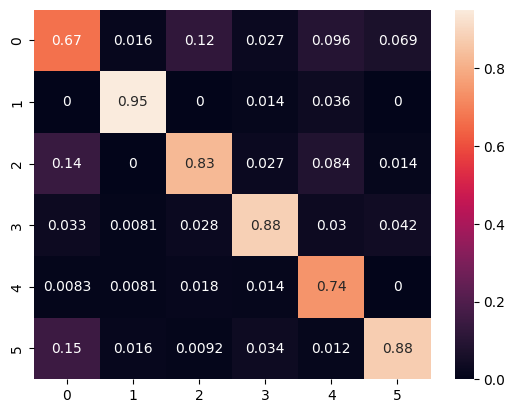

In [ ]:
rnn_model.test(dataset_test,batch_size=batch_size)

Hasonlítási alapként a feladatot CNN + MLP-vel is megoldottam. A modell a videók mintavételzett framejein tanul, ehhez módósítanom kellett a dataloadert. Az MLPCremaDataLoaderAdapter a CremaDataLoader által kapott batch-eket flatten-eli.

In [ ]:
class MLPCremaDataLoaderAdapter(Sequence):
    def __init__(self,crema_loader: CremaDataloader):
        super().__init__()
        self.dataloader = crema_loader
        self.batch_size = crema_loader.batch_size * crema_loader.samples

    def __len__(self):
        return math.floor(len(self.dataloader.videos)*self.dataloader.samples / self.batch_size)

    def __getitem__(self, idx):
      x,y = self.dataloader.__getitem__(idx)
      x = x.reshape(self.batch_size,INPUT_SHAPE[0],INPUT_SHAPE[1],INPUT_SHAPE[2])
      y = np.repeat(y,self.dataloader.samples,axis=0).reshape(self.batch_size,y.shape[1])
      return x,y

    def get_used_labels(self):
        return np.repeat(self.dataloader.get_used_labels(),self.dataloader.samples)

 A CNN model (pretrained és feature extractor) ugyanaz mint az RNN esetén.

In [ ]:
class MlpModel(ClassificationModel):
  def __init__(self):
        super().__init__()
        self.cnn_input = keras.layers.Input(shape=INPUT_SHAPE)
        self.pretrained = tf.keras.applications.MobileNetV2(include_top=False,input_shape=INPUT_SHAPE)
        self.pretrained.trainable = False
        self.feature_extractor = tf.keras.Sequential([
            keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
            keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
            keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
            keras.layers.Flatten()
        ])
        x = self.cnn_input
        x = self.pretrained(x)
        x = self.feature_extractor(x)

        self.classifier = tf.keras.Sequential([
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(16, activation='linear'),
            keras.layers.Dense(len(EMOTIONS), activation='softmax'),
        ])

        x = self.classifier(x)
        self.model = keras.Model(inputs=self.cnn_input, outputs=x)

        self.model.summary()
        self.save_file = "mlp_model.weights.h5"

In [ ]:
mlp_batch_size = 320
mlp_video_sampes = 10
mlp_dataset_train, mlp_dataset_test, mlp_dataset_val = load_crema_dataset(batch_size=int(mlp_batch_size/mlp_video_sampes), samples=mlp_video_sampes)
mlp_dataset_train = MLPCremaDataLoaderAdapter(mlp_dataset_train)
mlp_dataset_test = MLPCremaDataLoaderAdapter(mlp_dataset_test)
mlp_dataset_val = MLPCremaDataLoaderAdapter(mlp_dataset_val)

7438 7438


In [ ]:
mlp_model = MlpModel()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ (None, 64)                  │         386,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_17 (Sequential)           │ (None, 6)                   │           2,710 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,646,998 (10.10 MB)

 Trainable params: 388,950 (1.48 MB)

 Non-trainable params: 2,258,048 (8.61 MB)

Epoch 1/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.2538 - loss: 1.7221 - val_accuracy: 0.3732 - val_loss: 1.5207
Epoch 2/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.4130 - loss: 1.4528 - val_accuracy: 0.3857 - val_loss: 1.5036
Epoch 3/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.4674 - loss: 1.3312 - val_accuracy: 0.4428 - val_loss: 1.3868
Epoch 4/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.5243 - loss: 1.2138 - val_accuracy: 0.4083 - val_loss: 1.5458
Epoch 5/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.5621 - loss: 1.1273 - val_accuracy: 0.3787 - val_loss: 1.7159
Epoch 6/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.5885 - loss: 1.0576 - val_accuracy: 0.4772 - val_loss: 1.3410
Epoch 7/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.6161 - loss: 0.9927 - val_accuracy: 0.5240 - val_loss: 1.2214
Epoch 8/12
162/162 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.6434 - loss: 0.9285 - val_accu

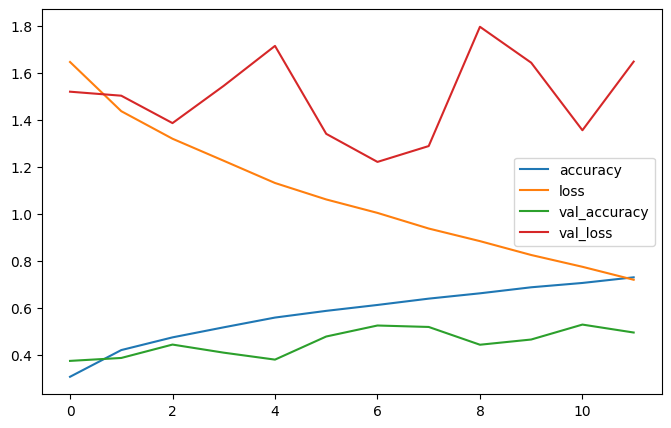

In [ ]:
mlp_model.train(mlp_dataset_train,mlp_dataset_val,n_epochs=12,batch_size=mlp_batch_size)

23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 814ms/step - accuracy: 0.6255 - loss: 1.1327
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 820ms/step
The accuracy on the test data is:  0.6195651888847351


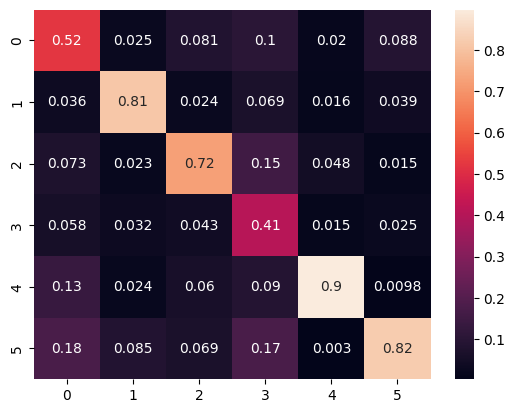

In [ ]:
mlp_model.test(mlp_dataset_test,batch_size=mlp_batch_size)

Az RNN és MLP model összehasonlítása. Új teszt dataloaderrel prediktálok minden videóra a két modellel.

In [ ]:
mlp_good_preds = []
rnn_good_preds = []

_,dataset_test,_ = load_crema_dataset(split_test=0.4)
samples_size = len(dataset_test)


for i in range(samples_size):
    samples = dataset_test.samples
    batch_x,batch_y = dataset_test.__getitem__(i)
    actual_classes = np.argmax(batch_y,axis=1)
    rnn_video_preds = np.argmax(rnn_model.model(batch_x),axis=1)
    mlp_video_preds = []
    for i in range(dataset_test.batch_size):
        video = batch_x[i]
        video_pred = mlp_model.model(video)
        preds_for_frame = np.argmax(video_pred,axis=1)
        mlp_video_preds.append(index_of_most_frequent(preds_for_frame))
    mlp_video_preds = np.array(mlp_video_preds)
    mlp_predicted_amount = np.count_nonzero(mlp_video_preds == actual_classes)
    rnn_predicted_amount = np.count_nonzero(rnn_video_preds == actual_classes)
    mlp_good_preds.append(mlp_predicted_amount)
    rnn_good_preds.append(rnn_predicted_amount)

mlp_good_preds_sum = sum(mlp_good_preds)
rnn_good_preds_sum = sum(rnn_good_preds)

print(f"Out of {samples_size*dataset_test.batch_size} samples")
print(f"MLP good predictions {mlp_good_preds_sum}")
print(f"RNN good predictions {rnn_good_preds_sum}")

7442 7442
Out of 2976 samples
MLP good predictions 2127
RNN good predictions 2393


In [ ]:
files_to_predict = ["1001_DFA_ANG_XX.mp4","1079_WSI_FEA_XX.mp4","1080_IEO_DIS_HI.mp4","1081_IEO_HAP_HI.mp4","1081_ITS_ANG_XX.mp4","1082_IEO_SAD_HI.mp4","1083_IEO_SAD_LO.mp4","1083_IOM_ANG_XX.mp4"]

videos,labels = files_to_predict , [get_label(i) for i in files_to_predict]

pred_loader = CremaDataloader(videos,labels,"/content/dataset/Extracted",20,len(files_to_predict))

y_prob = rnn_model.model.predict(pred_loader)
y_hat = np.argmax(y_prob,axis=1)

for i in range(len(files_to_predict)):
    print(f"Prediction for {files_to_predict[i]} is {decode_emotion(y_hat[i])} actual label {decode_emotion(labels[i])}")

sad_pred = np.round(y_prob[-2],2)
ang_pred = np.round(y_prob[-1],2)

print(f"Probality of classes for sad video {sad_pred}")
print(f"Probality of classes for angry video {ang_pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
Prediction for 1001_DFA_ANG_XX.mp4 is ANG actual label ANG
Prediction for 1079_WSI_FEA_XX.mp4 is FEA actual label FEA
Prediction for 1080_IEO_DIS_HI.mp4 is DIS actual label DIS
Prediction for 1081_IEO_HAP_HI.mp4 is HAP actual label HAP
Prediction for 1081_ITS_ANG_XX.mp4 is ANG actual label ANG
Prediction for 1082_IEO_SAD_HI.mp4 is SAD actual label SAD
Prediction for 1083_IEO_SAD_LO.mp4 is SAD actual label SAD
Prediction for 1083_IOM_ANG_XX.mp4 is SAD actual label ANG
Probality of classes for sad video [0.92 0.   0.08 0.   0.   0.  ]
Probality of classes for angry video [0.88 0.   0.06 0.02 0.04 0.  ]


Súly fájlok kiírása és lecsatlakozás a drive-ról.

In [ ]:
drive.flush_and_unmount()